# Imbalanced Data Learning Methods (for Binary Classification)
---
Data: http://sci2s.ugr.es/keel/imbalanced.php

**Also:** Is there a recognizable difference between the latent structure of naturally imbalanced data and artificially imbalanced data? (i.e. data in which one class is naturally much more prevalent than another, vs. data which is naturally balanced but which has had a subset of one class randomly downsampled)

In [775]:
import re
import os
from time import time

import numpy as np
import pandas as pd

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import tensorflow as tf
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier

import imblearn as imb
import imblearn.under_sampling
import imblearn.over_sampling
import imblearn.ensemble

## *Get the Data*

In [931]:
directory = "../data/"
file = "page-blocks0.dat"
path = os.path.join(directory, file)

with open(path, "r") as f:
    raw = f.read()
    
metadata = re.search(r"([\s\S]*)@data", raw).group(1).strip().split("\n")
data = re.search(r"@data([\s\S]*)", raw).group(1).strip().split("\n")
data = [x.split(", ") for x in data]

X_raw = np.array([[float(x) for x in example[:-1]] for example in data])
labels =  [example[-1] for example in data]
y_raw = np.array([1 if x == "positive" else 0 for x in labels])

def normalize(X, stats=None):
    
    if not stats:
        sigma = np.std(X, axis = 0)
        mu = np.mean(X, axis = 0)
        stats = {"sigma": sigma, "mu": mu}
        
    X_normed = (X - stats["mu"])/stats["sigma"] 

    return X_normed, stats

## *Explore the Data*

In [862]:
X_normed, stats = normalize(X_raw)
y_pos_ix = [i for i, v in enumerate(y_raw) if v == 1]
y_neg_ix = [i for i, v in enumerate(y_raw) if v == 0]

In [863]:
X_normed.shape, len(y_pos_ix), len(y_neg_ix)

((5472, 10), 559, 4913)

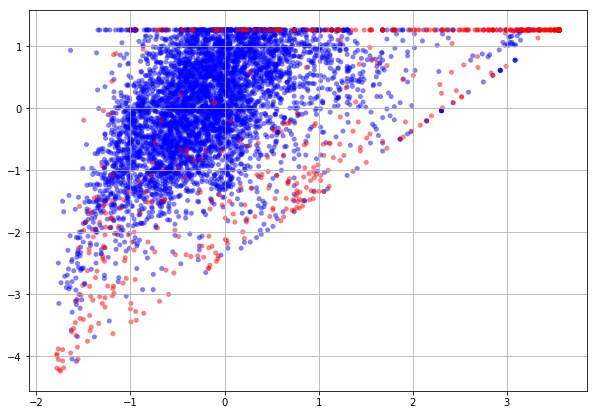

In [864]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(1, 1, 1) # aspect = "equal"
ax.grid(True)

alpha = 0.5
red = [1, 0, 0, alpha]
blue = [0, 0, 1, alpha]

def make_scatter(X, indices, color, label, dims = [0, 1]):
    
    [dim_A, dim_B] = dims 
    point_size = 100
    
    ax.scatter(X[indices, dim_A], 
               X[indices, dim_B], 
               s = point_size,
               c = color,
               label = label,
               marker = ".",
               edgecolors = "none")

make_scatter(X_normed, y_neg_ix, blue, "negative", [4, 5])
make_scatter(X_normed, y_pos_ix, red, "positive", [4, 5])

plt.show()

In [162]:
def reduce_dim(matrix, dims, seed=1):
    
    tic =time()
    print('Performing Truncated SVD...')
    svd = TruncatedSVD(n_components = dims, random_state = seed)
    X = svd.fit_transform(matrix) # matrix.shape = (n_samples, n_features)
    toc = time()
    print('Embeddings reduced from %d to %d dimensions through TruncatedSVD. (Time elapsed: %.2f s)' 
          % (matrix.shape[1], dims, (toc-tic)))
    return X

def TSNE2D(X, seed=1):
    
    tic = time()
    print('Performing TSNE...')
    X_embedded = TSNE(n_components=2, perplexity=30, random_state = seed).fit_transform(X)
    toc = time()
    print('Embeddings reduced to 2 dimensions through TSNE. (Time elapsed: %.2f s)' % (toc-tic))
    return X_embedded

# X_SVD = reduce_dim(X_normed, 2)
# X_TSNE = TSNE2D(X_normed)

In [163]:
X_TSNE_2 = TSNE(n_components=2, perplexity=100, random_state = 1).fit_transform(X_normed)

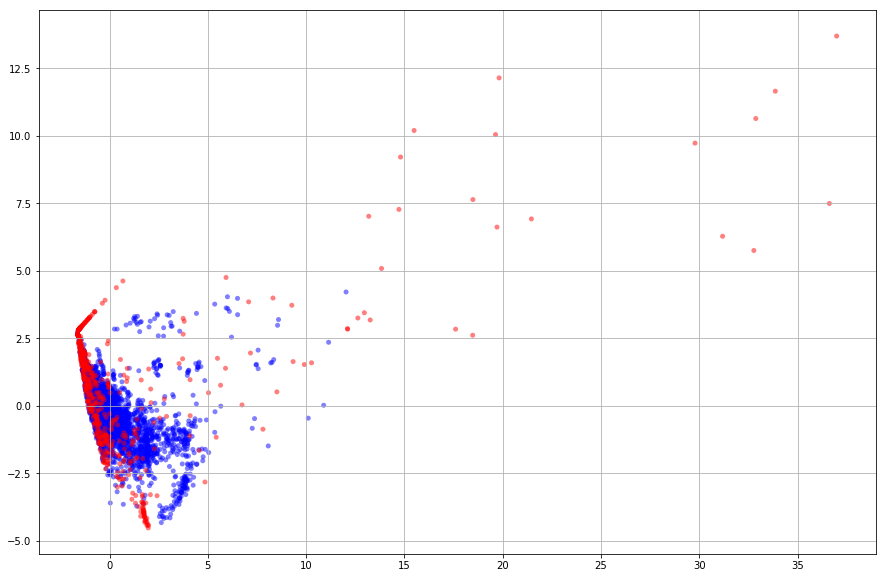

In [147]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(1, 1, 1) # aspect = "equal"
ax.grid(True)

make_scatter(X_SVD, y_neg_ix, blue, "negative")
make_scatter(X_SVD, y_pos_ix, red, "positive")
# make_scatter(X_SVD, y_neg_ix, blue, "negative")

plt.show()

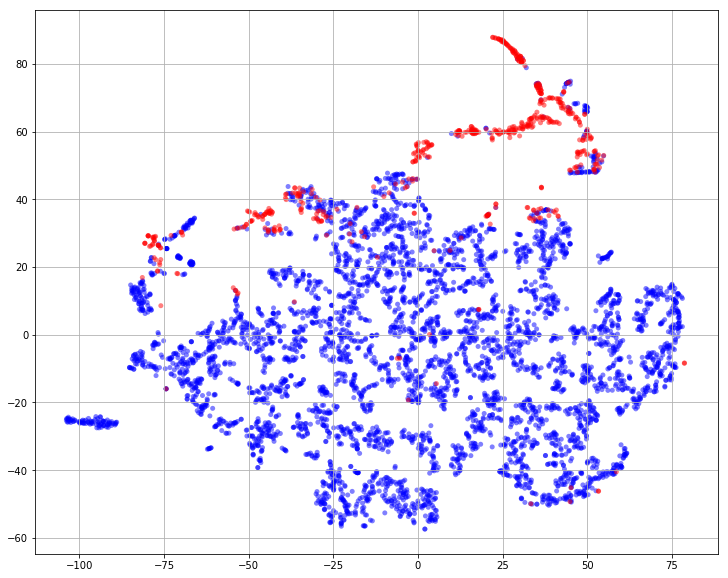

In [136]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(1, 1, 1, aspect = "equal") # aspect = "equal"
ax.grid(True)

make_scatter(X_TSNE, y_neg_ix, blue, "negative")
make_scatter(X_TSNE, y_pos_ix, red, "positive")

plt.show()

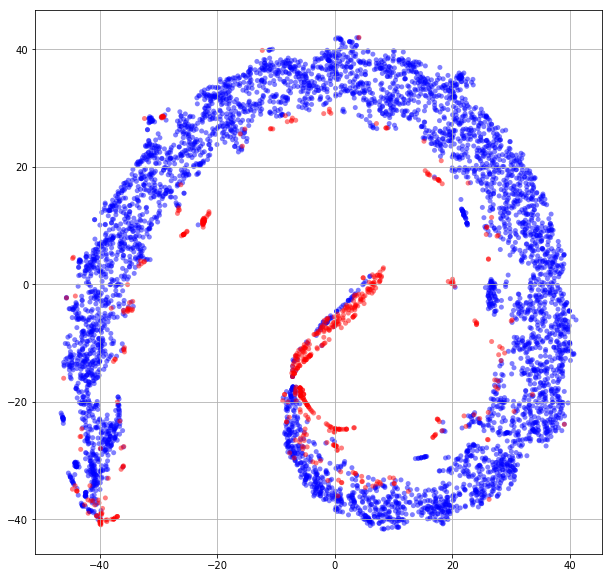

In [857]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(1, 1, 1, aspect = "equal") # aspect = "equal"
ax.grid(True)

make_scatter(X_TSNE_2, y_neg_ix, blue, "negative")
make_scatter(X_TSNE_2, y_pos_ix, red, "positive")

plt.show()

---

## *Split Data into Train/Valid/Test Sets*

In [1008]:
indices = np.array([v for v in range(len(y_raw))])
np.random.shuffle(indices)

fractions = [0.7, 0.2, 0.1]

m = len(y_raw)
m_train = int(fractions[0] * m)
m_valid = int(fractions[1] * m)
m_test = m - m_train - m_valid

ix_train = indices[:m_train]
ix_valid = indices[m_train:-m_test]
ix_test = indices[-m_test:]

X_raw_train = X_raw[ix_train]
X_raw_valid = X_raw[ix_valid]
X_raw_test = X_raw[ix_test]

XX = {}
XX["train"], stats = normalize(X_raw_train)
XX["valid"], _ = normalize(X_raw_valid, stats)
XX["test"], _ = normalize(X_raw_test, stats)

yy = {}
yy["train"] = y_raw[ix_train]
yy["valid"] = y_raw[ix_valid]
yy["test"] = y_raw[ix_test]

print(indices)

[4358 2817 3468 ... 5295 1516 2398]


---

## *Set up LogReg Optimization Procedure*

* When there is a class imbalance, choose the regularization constant such that the **PR AUC** (area under the precision-recall curve; equivalently, the **"average precision"**) is maximized, **not** the ROC AUC (area under the receiver operating characteristic curve).  

In [1009]:
c_params = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 10, 100, 1000]

def color_scatter(x, 
                  y, 
                  color_values, 
                  color_label="Threshold Value", 
                  figsize=(10, 7)):
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1, aspect = "equal")
    ax.grid(True)
    
    ax.scatter(x, 
               y, 
               s = 100, 
               c = color_values, 
               cmap = "jet", 
               marker = ".",
               edgecolors = "none")
    
    norm = matplotlib.colors.Normalize(0, 1)
    sm = plt.cm.ScalarMappable(norm = norm, cmap = "jet")
    sm.set_array([])
    cbar = fig.colorbar(sm, ticks = np.linspace(0, 1, 11))
    cbar.set_label(color_label)
    
    return fig, ax

def plot_roc(roc_data, title="ROC Curve"):
    
    (fpr, tpr, thresh_values) = roc_data
    thresh_values[0] = 0
    thresh_values[-1] = 1
    
    fig, ax = color_scatter(fpr, tpr, thresh_values)
    
    ax.plot([0, 1], [0, 1], "k-")
    
    ax.set_xlabel("FPR [= FP/(FP + TN)]")
    ax.set_ylabel("TPR [= TP/(TP + FN)]")
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    return plt.show()

def plot_prc(prc_data, y_true, title="Precision Recall Curve"):

    (precision, recall, thresh_values) = prc_data
    
    length = min([len(precision), len(recall), len(thresh_values)])
    precision = precision[:length]
    recall = recall[:length]
    thresh_values = thresh_values[:length]
    
    assert len(precision) == len(recall)
    assert len(recall) == len(thresh_values)
    
    thresh_values[0] = 0
    thresh_values[-1] = 1
    
    m = len(y_true)
    num_class_0 = len([v for v in y_true if v == 0])
    num_class_1 = m - num_class_0
    imbalance = min(np.array([num_class_0, num_class_1]) / m)
    
    fig, ax = color_scatter(recall, precision, thresh_values)
    
    ax.plot([0, 1], [imbalance, imbalance], "k-")
    
    ax.set_xlabel("Recall [= TPR = TP/(TP + FN)]")
    ax.set_ylabel("Precision [= TP/(TP + FP)]")
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    return plt.show()

def plot_prediction_dist(y, 
                         probs, 
                         labels=["0", "1"], 
                         title="Prediction Distributions", 
                         bins=40):
    
    class_0_ix = [i for i, v in enumerate(y) if v == 0]
    class_1_ix = [i for i, v in enumerate(y) if v == 1]
    
    class_0_probs = probs[class_0_ix]
    class_1_probs = probs[class_1_ix]
    
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.hist([class_0_probs, class_1_probs],
            bins = bins,
            alpha = 0.8,
            color = ["blue", "red"],
            label = labels)
    
    ax.set_xlabel("LogReg Prediction Probability")
    ax.set_ylabel("Number of Examples")
    ax.set_xlim(0, 1)
    ax.set_title(title)
    plt.legend(loc = "upper right")
    
    return plt.show()

def get_model_metrics(y, pred):
    
    roc = roc_curve(y, pred)
    roc_auc = roc_auc_score(y, pred)
    prc = precision_recall_curve(y, pred)
    pr_auc = average_precision_score(y, pred)
    
    metrics = {
        "roc": roc,
        "roc_auc": roc_auc,
        "prc": prc,
        "pr_auc": pr_auc
    }
    
    return metrics

def tune_log_reg(XX, yy, c_params):

    pred = {}
    metrics = {}
    log_reg_models = {}

    count = 0

    for C in c_params:    

        log_reg = LogisticRegression(penalty = "l2", C = C, random_state = 0)
        log_reg.fit(XX["train"], yy["train"])

        pred[C] = {
            "train": log_reg.predict_proba(XX["train"])[:, 1],
            "valid": log_reg.predict_proba(XX["valid"])[:, 1]
        }
        
        metrics[C] = {
            "train": get_model_metrics(yy["train"], pred[C]["train"]),
            "valid": get_model_metrics(yy["valid"], pred[C]["valid"])
        }
        
        log_reg_models[C] = log_reg

        count += 1

    pr_aucs_valid = [[metrics[C]["valid"]["pr_auc"], C] for C in c_params]
    prc_best = max(pr_aucs_valid)
    C_best = prc_best[1]
    C_best_index = c_params.index(C_best)
    
    log_reg_best = log_reg_models[C_best]

    # Calculate test metrics from best model
    pred[C_best]["test"] = log_reg.predict_proba(XX["test"])[:, 1]
    metrics[C_best]["test"] = get_model_metrics(yy["test"], pred[C_best]["test"])

    result = {
        
        "pred": pred,
        "metrics": metrics,
        "models": log_reg_models,
        "best_param": {
            "index": C_best_index, 
            "C": C_best
        }
    }

    print("Best Valid ROC AUC: %f" % metrics[C_best]["valid"]["roc_auc"])
    print(" Best Valid PR AUC: %f" % metrics[C_best]["valid"]["pr_auc"])
    print("      Test ROC AUC: %f" % metrics[C_best]["test"]["roc_auc"])
    print("       Test PR AUC: %f" % metrics[C_best]["test"]["pr_auc"])
    print("        Best Param: [%d] --> %f" % (c_params.index(C_best), C_best))

    return result, C_best_index

def plot_result(result, yy, c_param_index=0, c_params=c_params):
    
    C = c_params[c_param_index]
    C_best = result["best_param"]["C"]
    
    plot_prediction_dist(yy["valid"], 
                         result["pred"][C]["valid"], 
                         title = "Prediction Distributions (Valid): C = %g" % C)
    
    plot_prediction_dist(yy["test"], 
                         result["pred"][C_best]["test"], 
                         title = "Prediction Distributions (Test): C = %g" % C_best)
    
    plot_roc(result["metrics"][C]["valid"]["roc"], 
             title = "ROC Curve (Valid): C = %g" % C)
    
    plot_roc(result["metrics"][C_best]["test"]["roc"], 
             title = "ROC Curve (Test): C = %g" % C_best)
    
    plot_prc(result["metrics"][C]["valid"]["prc"], 
             yy["valid"], 
             title = "Precision Recall Curve (Valid): C = %g" % C)
    
    plot_prc(result["metrics"][C_best]["test"]["prc"], 
             yy["test"], 
             title = "Precision Recall Curve (Test): C = %g" % C_best)
    
    return None

## Classification without Modification

In [1010]:
result, C_best = tune_log_reg(XX, yy, c_params)

Best Valid ROC AUC: 0.914705
 Best Valid PR AUC: 0.691377
      Test ROC AUC: 0.974112
       Test PR AUC: 0.853485
        Best Param: [7] --> 0.200000


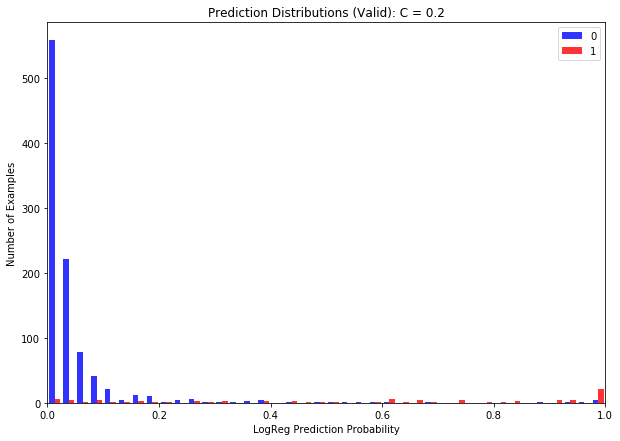

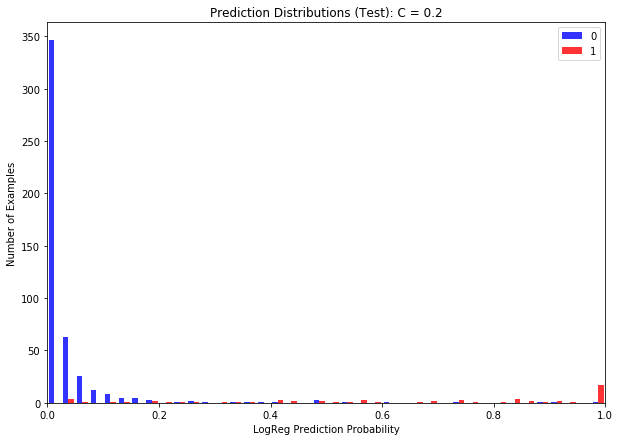

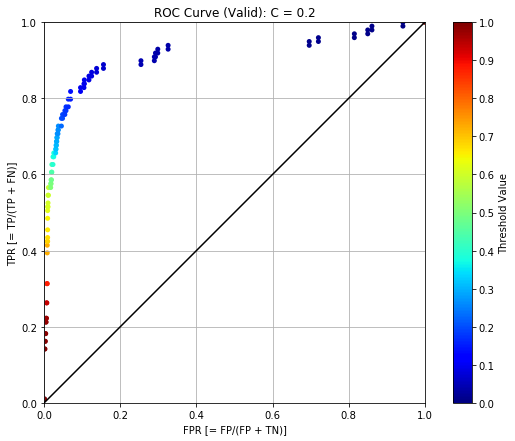

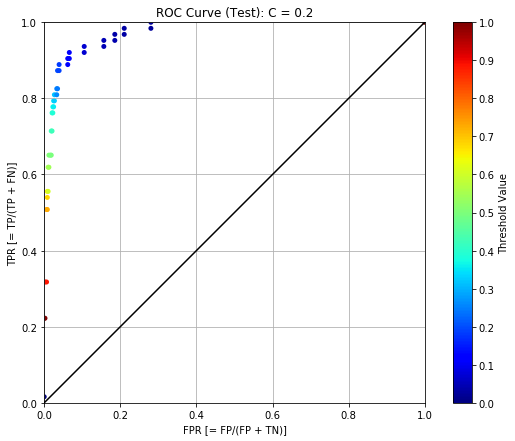

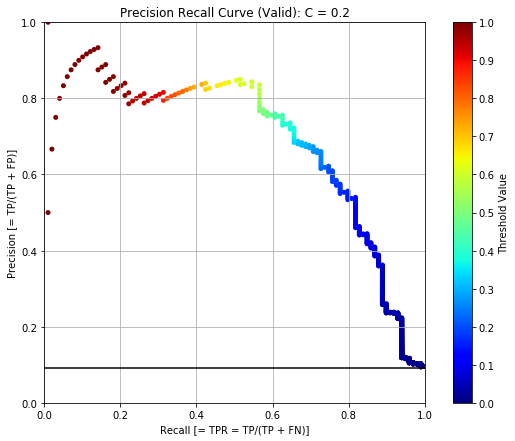

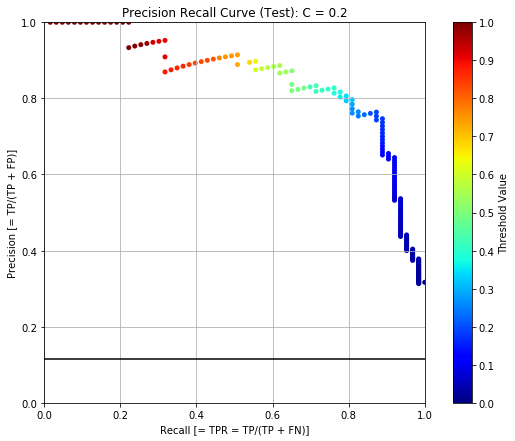

In [1011]:
plot_result(result, yy, C_best)

## Random Undersampling

In [1012]:
rus = RandomUnderSampler(random_state = 124)
X_under_train, y_under_train = rus.fit_sample(XX["train"], yy["train"])

XX_under = {
    "train": X_under_train,
    "valid": XX["valid"],
    "test": XX["test"]
}

yy_under = {
    "train": y_under_train,
    "valid": yy["valid"],
    "test": yy["test"]
}

result_under, C_best_under = tune_log_reg(XX_under, yy_under, c_params)

Best Valid ROC AUC: 0.929191
 Best Valid PR AUC: 0.670800
      Test ROC AUC: 0.980036
       Test PR AUC: 0.849261
        Best Param: [8] --> 0.500000


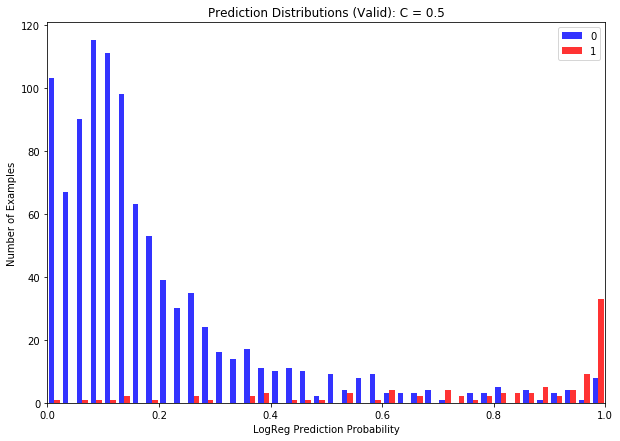

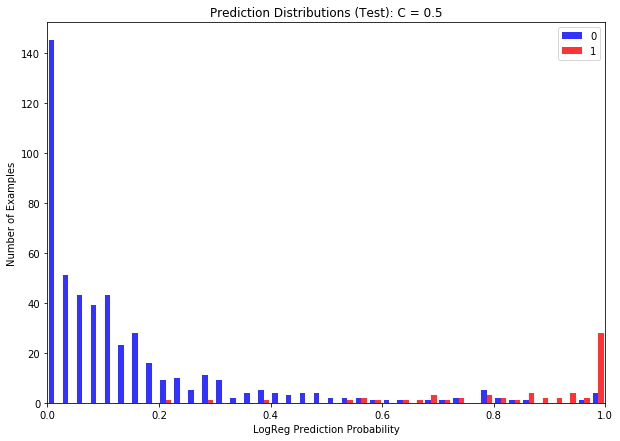

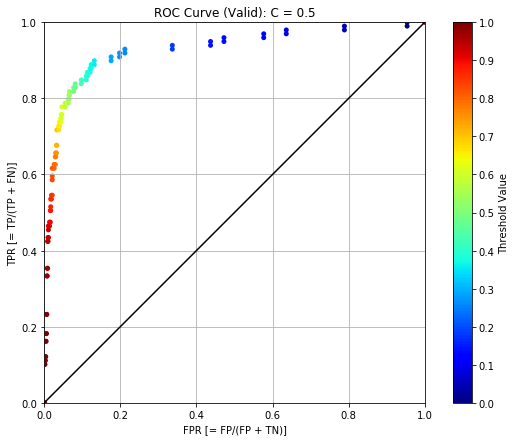

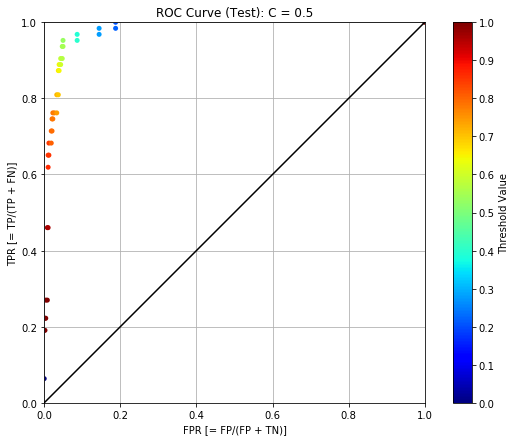

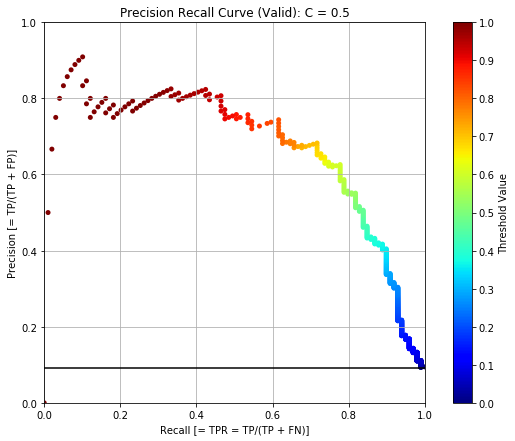

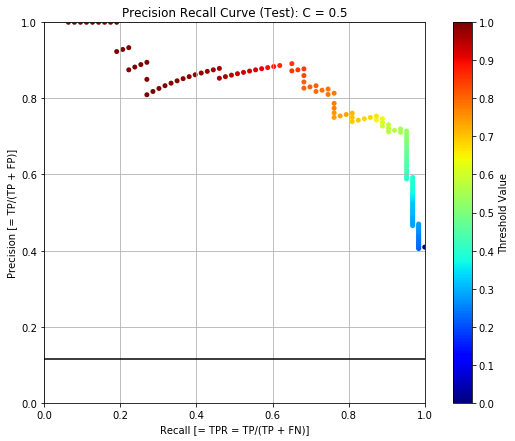

In [1013]:
plot_result(result_under, yy_under, C_best_under)

## Random Oversampling

In [1014]:
ros = RandomOverSampler(random_state = 124)
X_over_train, y_over_train = ros.fit_sample(XX["train"], yy["train"])

XX_over = {
    "train": X_over_train,
    "valid": XX["valid"],
    "test": XX["test"]
}

yy_over = {
    "train": y_over_train,
    "valid": yy["valid"],
    "test": yy["test"]
}

result_over, C_best_over = tune_log_reg(XX_over, yy_over, c_params)

Best Valid ROC AUC: 0.930460
 Best Valid PR AUC: 0.671958
      Test ROC AUC: 0.982163
       Test PR AUC: 0.856415
        Best Param: [6] --> 0.100000


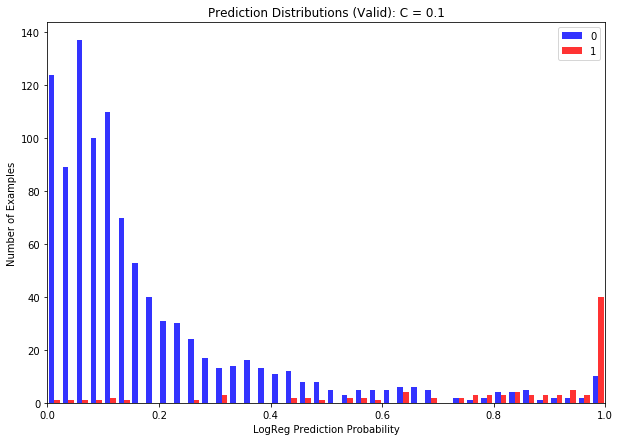

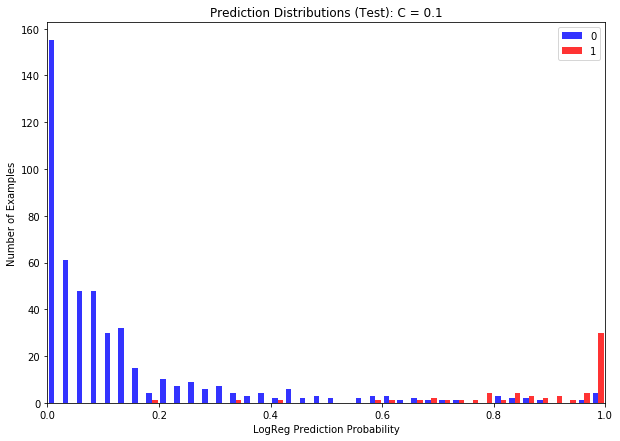

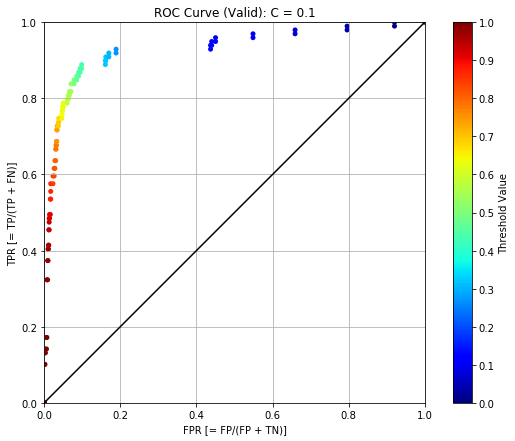

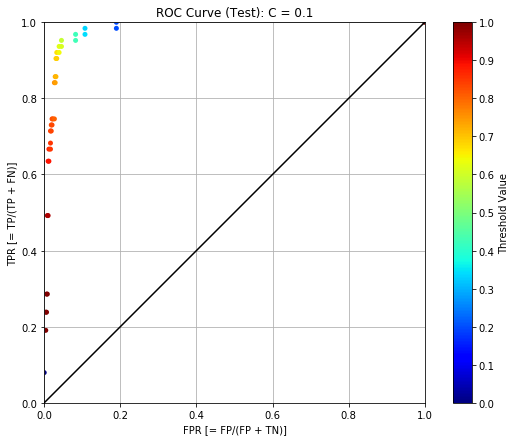

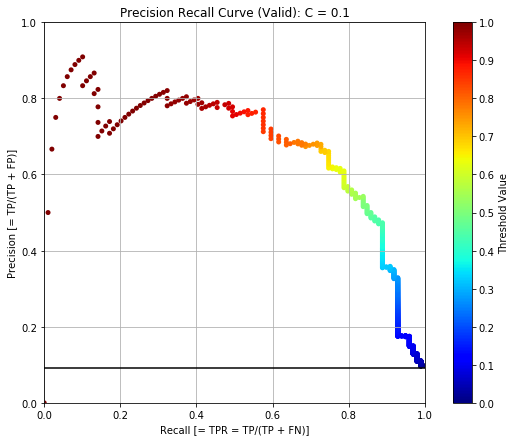

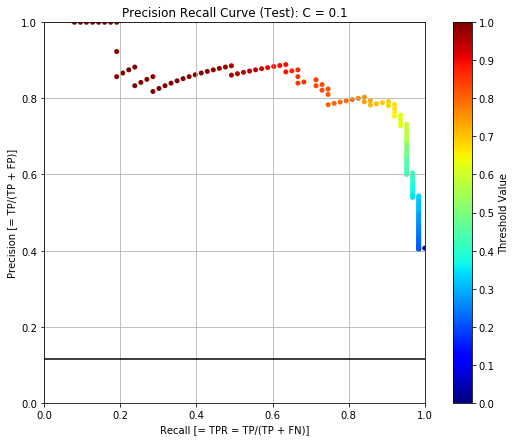

In [1015]:
plot_result(result_over, yy_over, C_best_over)

## SMOTE Oversampling

In [1016]:
smote = SMOTE(random_state = 101)
X_SMOTE_train, y_SMOTE_train = smote.fit_sample(X["train"], y["train"])

XX_SMOTE = {
    "train": X_SMOTE_train,
    "valid": XX["valid"],
    "test": XX["test"]
}

yy_SMOTE = {
    "train": y_SMOTE_train,
    "valid": yy["valid"],
    "test": yy["test"]
}

result_SMOTE, C_best_SMOTE = tune_log_reg(XX_SMOTE, yy_SMOTE, c_params)

Best Valid ROC AUC: 0.927963
 Best Valid PR AUC: 0.681657
      Test ROC AUC: 0.974963
       Test PR AUC: 0.828756
        Best Param: [8] --> 0.500000


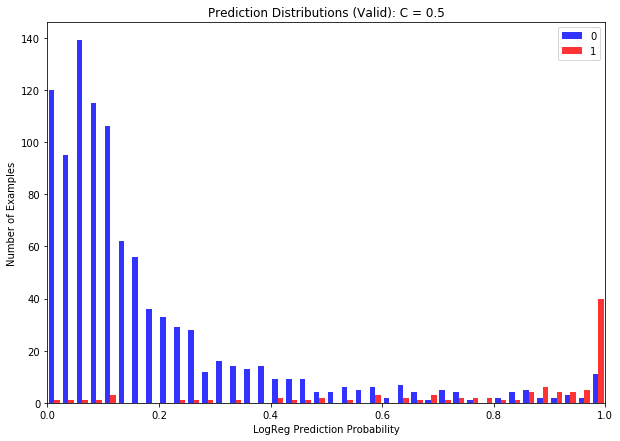

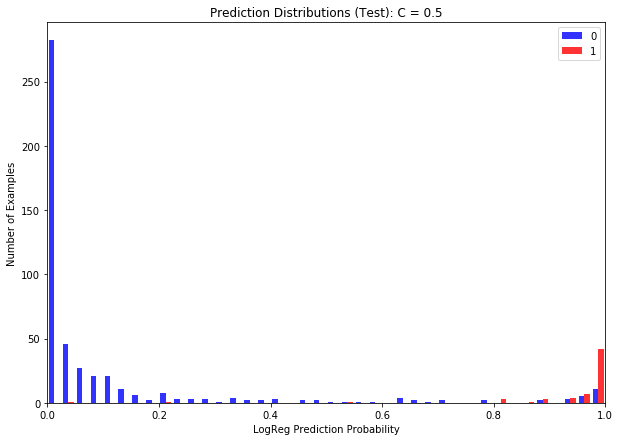

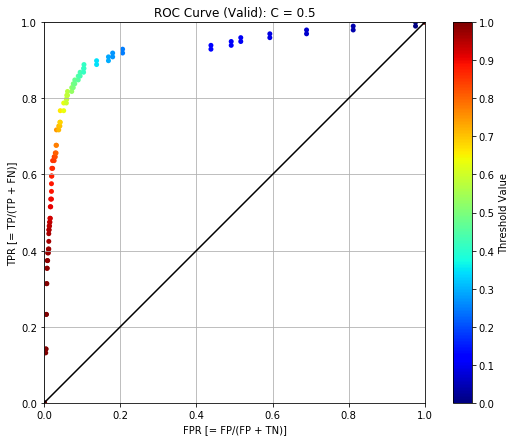

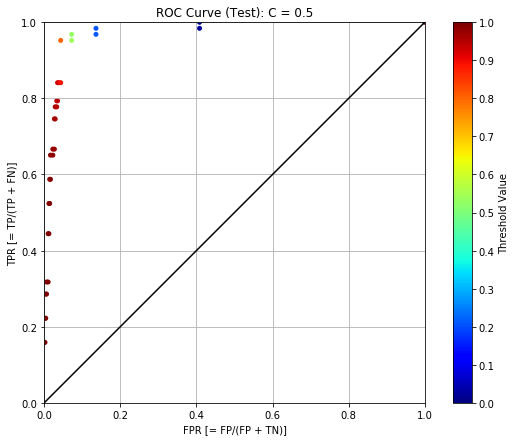

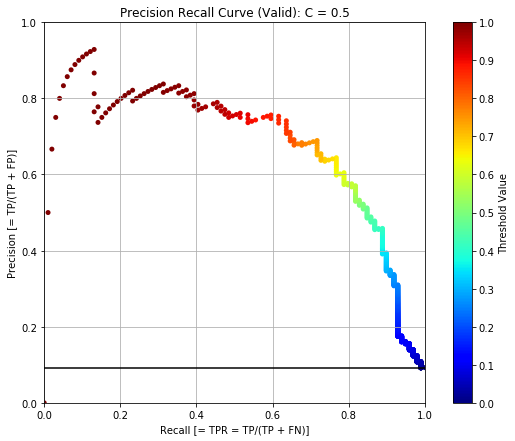

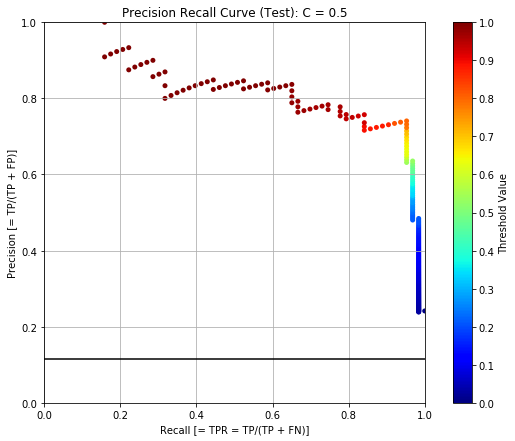

In [1017]:
plot_result(result_SMOTE, yy_SMOTE, C_best_SMOTE)

## Bagging

ROC AUC:  0.9619853204439671
 PR AUC:  0.793243958560955


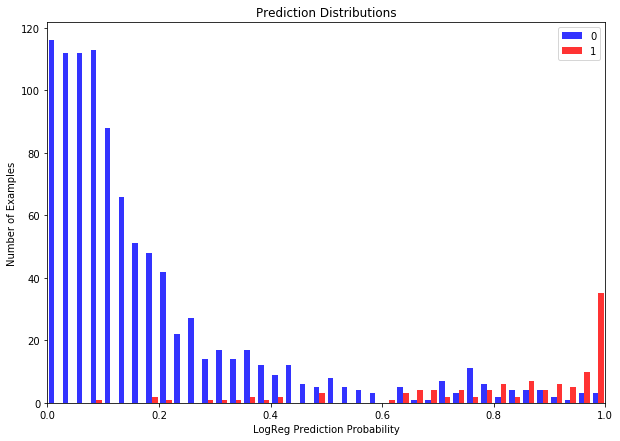

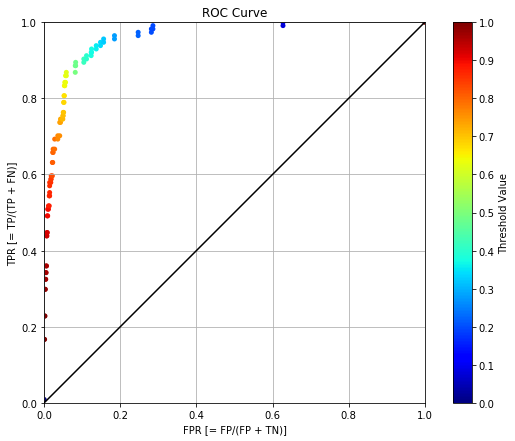

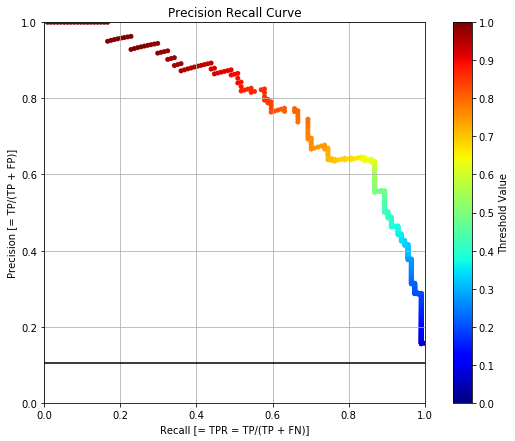

In [1018]:
bbc = BalancedBaggingClassifier(base_estimator = LogisticRegression())
bbc.fit(XX["train"], yy["train"])

y_pred_bbc = bbc.predict_proba(X_valid)[:, 1]
metrics = get_model_metrics(y_valid, y_pred_bbc)

print("ROC AUC: ", metrics["roc_auc"])
print(" PR AUC: ", metrics["pr_auc"])

plot_prediction_dist(y_valid, y_pred_bbc)
plot_roc(metrics["roc"])
plot_prc(metrics["prc"], y_valid)

## Sigmoid Neural Network

## Sigmoid-weighted sigmoid ensemble